# 02 - Modelo Lineal: Clasificación de Sentimientos

Este notebook aplica un **modelo lineal (Logistic Regression)** para clasificar el sentimiento de posts en redes sociales.

**Dataset:** SocialBuzz Sentiment Analytics (732 muestras)

**Target:** Sentimiento agrupado en 3 clases: `Positivo`, `Neutro`, `Negativo`

**Features:** TF-IDF sobre texto + features numéricas (Retweets, Likes, Year, Month, Day, Hour)

## 0) Instalación e importación de librerías

In [1]:
try:
    import kagglehub
except ImportError:
    import subprocess
    subprocess.run(['pip', 'install', 'kagglehub', '-q'])
    import kagglehub

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

## 1) Carga de datos

In [3]:
#Cargamos los datos desde kagglehub:
path = kagglehub.dataset_download('eshummalik/socialbuzz-sentiment-analytics')
file_path = os.path.join(path, 'sentimentdataset.csv')
df = pd.read_csv(file_path)

print(f'Shape: {df.shape}')
df.head(3)

100%|██████████| 50.9k/50.9k [00:00<00:00, 42.1MB/s]

Extracting files...
Shape: (732, 15)


,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15


## 2) Preprocesado

In [4]:
#Limpiamos texto y sentimiento:
df['Text'] = df['Text'].astype(str).str.strip()
df['Sentiment'] = df['Sentiment'].astype(str).str.strip()

#Mapeamos los sentimientos a 3 clases (positivo, negativo, neutro):
POSITIVE_EMOTIONS = {
    'Joy', 'Positive', 'Happiness', 'Happy', 'Excitement', 'Elation', 'Euphoria',
    'Love', 'Gratitude', 'Contentment', 'Optimism', 'Hope', 'Hopeful', 'Satisfaction',
    'Pride', 'Proud', 'Amusement', 'Awe', 'Inspiration', 'Inspired', 'Enthusiasm',
    'Confidence', 'Confident', 'Empowerment', 'Freedom', 'Courage', 'Determination',
    'Accomplishment', 'Celebration', 'Serenity', 'Tranquility', 'Peace', 'Calmness',
    'Positivity', 'Blessed', 'Warmth', 'Heartwarming', 'Tenderness', 'Affection',
    'Admiration', 'Adoration', 'Amazement', 'Wonder', 'Wonderment', 'Enchantment',
    'Captivation', 'Marvel', 'Charm', 'Playful', 'PlayfulJoy', 'FestiveJoy',
    'JoyfulReunion', 'Overjoyed', 'Ecstasy', 'Triumph', 'Success', 'Fulfillment',
    'Gratitude', 'Appreciation', 'Relieved', 'Relief', 'Kindness', 'Kind',
    'Compassion', 'Compassionate', 'Sympathy', 'Empathetic', 'Friendship', 'Romance',
    'Connection', 'Harmony', 'Radiance', 'Zest', 'Energy', 'Vibrancy', 'Spark',
    'Breakthrough', 'Motivation', 'Resilience', 'Adventure', 'Exploration',
    'Curiosity', 'Imagination', 'Creativity', 'Creative Inspiration', 'ArtisticBurst',
    'Grateful', 'Rejuvenation', 'Journey', 'Mindfulness', 'Solace', 'Touched',
    'Acceptance', 'Nostalgic', 'Bittersweet', 'Whimsy', 'Free-spirited',
    'Dazzle', 'Hypnotic', 'Mesmerizing', 'Iconic', 'Melodic', 'Grandeur',
    'Reverence', 'Anticipation', 'Thrill', 'Thrilling Journey', 'Immersion',
    'Engagement', 'Celebration', 'Colorful', 'Elegance', 'Runway Creativity',
    'CulinaryOdyssey', 'Culinary Adventure', 'Joy in Baking', 'Adrenaline',
    "Nature's Beauty", "Ocean's Freedom", 'Celestial Wonder', 'Envisioning History',
    'Winter Magic', 'Whispers of the Past', 'Ruins', 'Enjoyment', 'Intrigue',
    'Immersion', 'DreamChaser', 'InnerJourney', 'Melodic', 'Arousal',
}

NEGATIVE_EMOTIONS = {
    'Negative', 'Sadness', 'Sad', 'Anger', 'Fear', 'Fearful', 'Despair', 'Desperation',
    'Grief', 'Sorrow', 'Heartbreak', 'Heartache', 'LostLove', 'Loss', 'Loneliness',
    'Isolation', 'Disappointment', 'Disappointed', 'Regret', 'Guilt', 'Shame',
    'Frustration', 'Frustrated', 'Anger', 'Hate', 'Resentment', 'Envy', 'Envious',
    'Jealousy', 'Jealous', 'Disgust', 'Betrayal', 'Bitterness', 'Bitter', 'Bad',
    'Desolation', 'Darkness', 'Suffering', 'Helplessness', 'Devastated', 'Overwhelmed',
    'Anxiety', 'Apprehensive', 'Pressure', 'Exhaustion', 'Numbness', 'Melancholy',
    'Pensive', 'Obstacle', 'Miscalculation', 'Intimidation', 'Dismissive',
    'EmotionalStorm', 'Mischievous',
}

NEUTRAL_EMOTIONS = {
    'Neutral', 'Indifference', 'Nostalgia', 'Reflection', 'Contemplation',
    'Ambivalence', 'Surprise', 'Confusion', 'Suspense', 'Yearning', 'Solitude',
    'Coziness', 'Embarrassed', 'Embarrassment',
}

def map_sentiment(sent):
    if sent in POSITIVE_EMOTIONS:
        return 'Positivo'
    elif sent in NEGATIVE_EMOTIONS:
        return 'Negativo'
    elif sent in NEUTRAL_EMOTIONS:
        return 'Neutro'
    else:
        pos_keywords = ['joy', 'happy', 'love', 'hope', 'good', 'great', 'excit', 'wonder',
                        'posit', 'glad', 'cheer', 'bright', 'amaz', 'thrill', 'bliss']
        neg_keywords = ['sad', 'bad', 'hate', 'fear', 'angry', 'angr', 'grief', 'depress',
                        'negat', 'despair', 'pain', 'sorrow', 'hurt', 'rage', 'bitter']
        s_lower = sent.lower()
        for kw in pos_keywords:
            if kw in s_lower:
                return 'Positivo'
        for kw in neg_keywords:
            if kw in s_lower:
                return 'Negativo'
        return 'Neutro'

df['sentiment_group'] = df['Sentiment'].apply(map_sentiment)

print('Distribución de clases agrupadas:')
print(df['sentiment_group'].value_counts())
print(f'\nTotal muestras: {len(df)}')

Distribución de clases agrupadas:
sentiment_group
Positivo    474
Negativo    175
Neutro       83
Name: count, dtype: int64

Total muestras: 732


In [5]:
le = LabelEncoder()
y = le.fit_transform(df['sentiment_group'])
print(f'Clases: {le.classes_}  ->  etiquetas: {list(range(len(le.classes_)))}')

#Features numéricas:
num_features = ['Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour']
X_num = df[num_features].fillna(0).values

#Dividimos en train/val/test (70/15/15)
X_text = df['Text'].values

#Primera división: train vs (val+test):
X_text_train, X_text_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
    X_text, X_num, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

#Segunda división: val vs test:
X_text_val, X_text_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
    X_text_temp, X_num_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

print(f'Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}')

Clases: ['Negativo' 'Neutro' 'Positivo']  ->  etiquetas: [0, 1, 2]
Train: 512 | Val: 110 | Test: 110


In [6]:
#TF-IDF sobre el texto:
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 2), sublinear_tf=True)
X_tfidf_train = tfidf.fit_transform(X_text_train)
X_tfidf_val   = tfidf.transform(X_text_val)
X_tfidf_test  = tfidf.transform(X_text_test)

#Combinamos TF-IDF + numéricas:
from scipy.sparse import hstack, csr_matrix
X_train = hstack([X_tfidf_train, csr_matrix(X_num_train)])
X_val   = hstack([X_tfidf_val,   csr_matrix(X_num_val)])
X_test  = hstack([X_tfidf_test,  csr_matrix(X_num_test)])

print(f'Dimensión de features: {X_train.shape[1]} (500 TF-IDF + 6 numéricas)')

Dimensión de features: 506 (500 TF-IDF + 6 numéricas)


## 3) Modelo Lineal: Logistic Regression

In [8]:
#Entrenamos Logistic Regression:
model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=RANDOM_STATE
)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

## 4) Evaluación en Train, Validación y Test

In [15]:
def evaluate(model, X, y_true, split_name, class_names):
    y_pred = model.predict(X)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f'\n=== {split_name} ===')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-Macro: {f1:.4f}')
    print(f'Precisión: {prec:.4f}')
    print(f'Recall:: {rec:.4f}')
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    return acc, f1, prec, rec

class_names = le.classes_

acc_train, f1_train, prec_train, rec_train = evaluate(model, X_train, y_train, 'TRAIN', class_names)
acc_val, f1_val, prec_val, rec_val = evaluate(model, X_val, y_val, 'VALIDACIÓN', class_names)
acc_test, f1_test, prec_test, rec_test = evaluate(model, X_test, y_test,'TEST', class_names)


=== TRAIN ===
Accuracy: 0.8555
F1-Macro: 0.7094
Precisión: 0.8945
Recall:: 0.6686
              precision    recall  f1-score   support

    Negativo       0.91      0.77      0.84       122
      Neutro       0.93      0.24      0.38        58
    Positivo       0.84      0.99      0.91       332

    accuracy                           0.86       512
   macro avg       0.89      0.67      0.71       512
weighted avg       0.87      0.86      0.83       512


=== VALIDACIÓN ===
Accuracy: 0.7182
F1-Macro: 0.4492
Precisión: 0.5149
Recall:: 0.4521
              precision    recall  f1-score   support

    Negativo       0.83      0.38      0.53        26
      Neutro       0.00      0.00      0.00        13
    Positivo       0.71      0.97      0.82        71

    accuracy                           0.72       110
   macro avg       0.51      0.45      0.45       110
weighted avg       0.66      0.72      0.65       110


=== TEST ===
Accuracy: 0.7455
F1-Macro: 0.5178
Precisión: 0.8306
R

## 5) Matriz de confusión (Test)

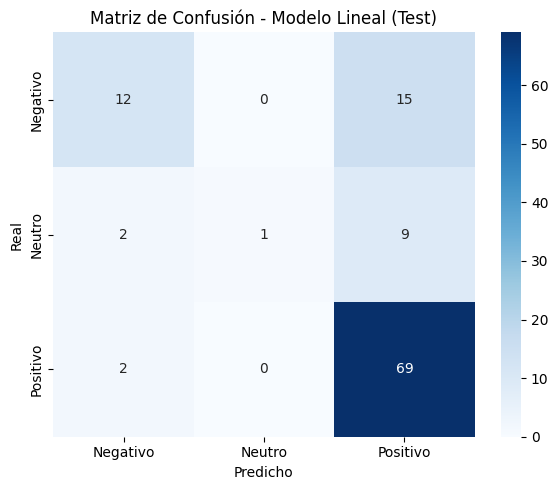

In [10]:
y_pred_test = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Modelo Lineal (Test)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 6) Resumen de Resultados

In [16]:
results = pd.DataFrame({
    'Split': ['Train', 'Validación', 'Test'],
    'Accuracy': [acc_train, acc_val, acc_test],
    'F1-Macro': [f1_train,  f1_val,  f1_test],
    'Precision': [prec_train, prec_val, prec_test],
    'Recall': [rec_train,  rec_val,  rec_test],
})

results = results.round(4)

print('\nRESUMEN MODELO LINEAL (Logistic Regression)')
print(results.to_string(index=False))

print('\nTabla Resultados:')
print(f"| Logistic Regression | N/A | {acc_train:.4f} | {acc_val:.4f} | {acc_test:.4f} | {f1_train:.4f} | {f1_val:.4f} | {f1_test:.4f} | {prec_train:.4f} | {prec_val:.4f} | {prec_test:.4f} | {rec_train:.4f} | {rec_val:.4f} | {rec_test:.4f} |")


RESUMEN MODELO LINEAL (Logistic Regression)
     Split  Accuracy  F1-Macro  Precision  Recall
     Train    0.8555    0.7094     0.8945  0.6686
Validación    0.7182    0.4492     0.5149  0.4521
      Test    0.7455    0.5178     0.8306  0.4999

Tabla Resultados:
| Logistic Regression | N/A | 0.8555 | 0.7182 | 0.7455 | 0.7094 | 0.4492 | 0.5178 | 0.8945 | 0.5149 | 0.8306 | 0.6686 | 0.4521 | 0.4999 |
